In [1]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3
Loading required package: grid
Loading required package: lattice
Loading required package: modeltools
Loading required package: stats4


# analysis

In [2]:
datasetName="/stor/public/hcad/lung_lung_HCLAdultLung2/lung_lung_HCLAdultLung2"

In [3]:
# scRNA
raw_data <- read.csv(paste0(datasetName, "_expression.tsv.gz"),header = TRUE, sep='\t',row.names = 1)

In [4]:
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv.gz"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv.gz"), h = T, sep = "\t", row.names = 1)

In [5]:
# build object
dataobj <- CreateSeuratObject(counts = raw_data, project = "HCAd",meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”

In [6]:
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))

Centering and scaling data matrix


In [7]:
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))

PC_ 1 
Positive:  SFTPB, MGP, SPARC, SFTPC, IGFBP7, SFTPA1, LUM, A2M, SFTPA2, C3 
	   MUC1, COL1A2, SLC34A2, COL3A1, DCN, NAPSA, CTGF, COL1A1, COL4A1, COL6A3 
	   SLPI, SFTPD, CYR61, FSTL1, SPARCL1, AGR2, CXCL17, C4BPA, BGN, C1S 
Negative:  FTL, HLA-DRA, LYZ, FCER1G, TYROBP, FTH1, APOC1, C1QB, ALOX5AP, C1QA 
	   AIF1, CTSS, MRC1, S100A4, LAPTM5, TMSB4X, MCEMP1, CD74, HLA-DRB1, C1orf162 
	   OLR1, CTSD, TREM2, MARCO, BCL2A1, CD52, MSR1, CAPG, ACP5, S100A9 
PC_ 2 
Positive:  A2M, SPARC, MGP, IGFBP7, LUM, DCN, COL3A1, COL1A2, TIMP1, COL1A1 
	   FN1, TMSB10, COL6A3, SPARCL1, COL4A1, MT-RNR2, CCL2, BGN, FSTL1, ADH1B 
	   POSTN, MFAP4, MMP2, COL4A2, VIM, B2M, C7, COL5A2, NNMT, FBLN1 
Negative:  SFTPB, SFTPC, SFTPA2, SFTPA1, SLC34A2, NAPSA, MUC1, CTSH, SFTPD, SERPINA1 
	   DHCR24, C4BPA, AGR2, LAMP3, LPCAT1, CXCL17, SCD, SLPI, SFTA2, AQP4 
	   HOPX, WIF1, LRRK2, PIGR, CLDN18, MAL2, STEAP4, SUSD2, SDC4, ATP11A 
PC_ 3 
Positive:  LUM, DCN, COL3A1, COL1A2, COL1A1, COL6A3, ADH1B, FN1, MFAP4, BGN 

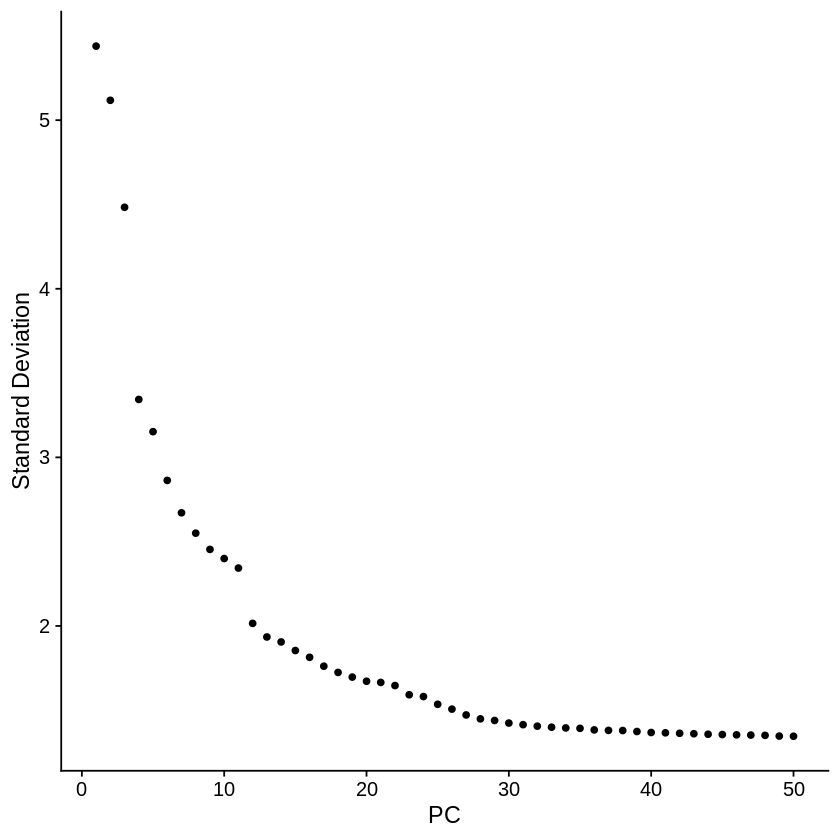

In [8]:
ElbowPlot(dataobj,50) 

In [9]:
pcDim = 30
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”19:36:06 UMAP embedding parameters a = 0.9922 b = 1.112
19:36:06 Read 6022 rows and found 30 numeric columns
19:36:06 Using Annoy for neighbor search, n_neighbors = 30
19:36:06 Building Annoy index with metric = cosine, n_trees = 50
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
19:36:07 Writing NN index file to temp file /tmp/RtmpO2hJpc/file6c5d5f972a74
19:36:07 Searching Annoy index using 1 thread, search_k = 3000
19:36:09 Annoy recall = 100%
19:36:09 Commencing smooth kNN distance calibration using 1 thread
19:36:10 Initializing from normalized Laplacian + noise
19:36:10 Commencing optimizatio

In [10]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster", pt.size=1) + NoLegend()
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”

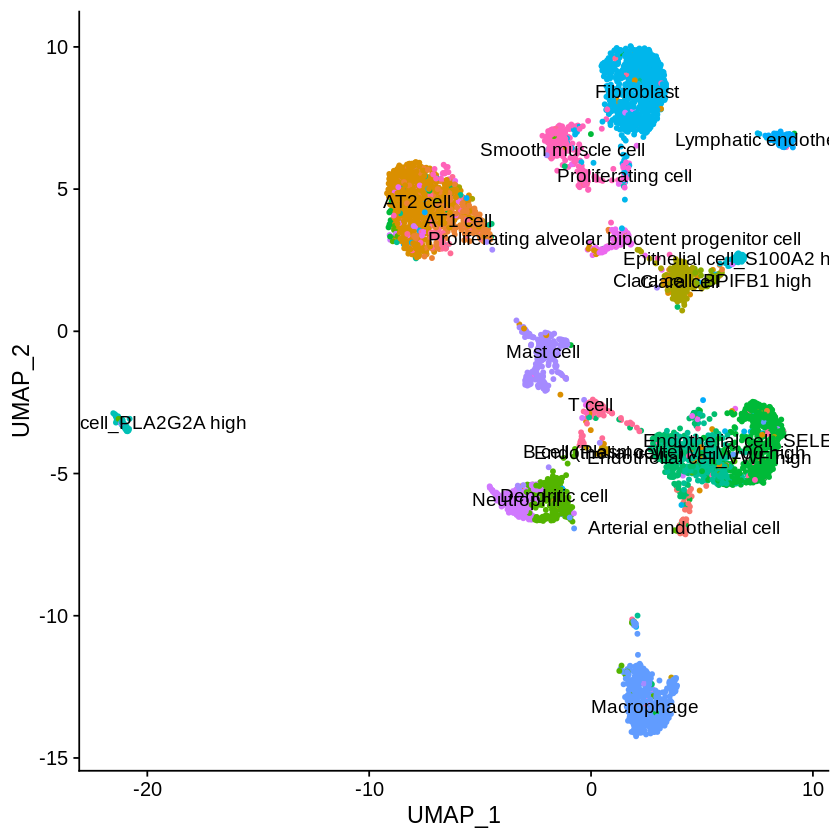

In [11]:
p_umap2

# Clustering

In [12]:
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)

Computing nearest neighbor graph
Computing SNN


In [13]:
dataobj <- FindClusters(dataobj, resolution = 1, n.start = 10)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6022
Number of edges: 267344

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8750
Number of communities: 20
Elapsed time: 0 seconds


In [14]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE, pt.size=1)
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

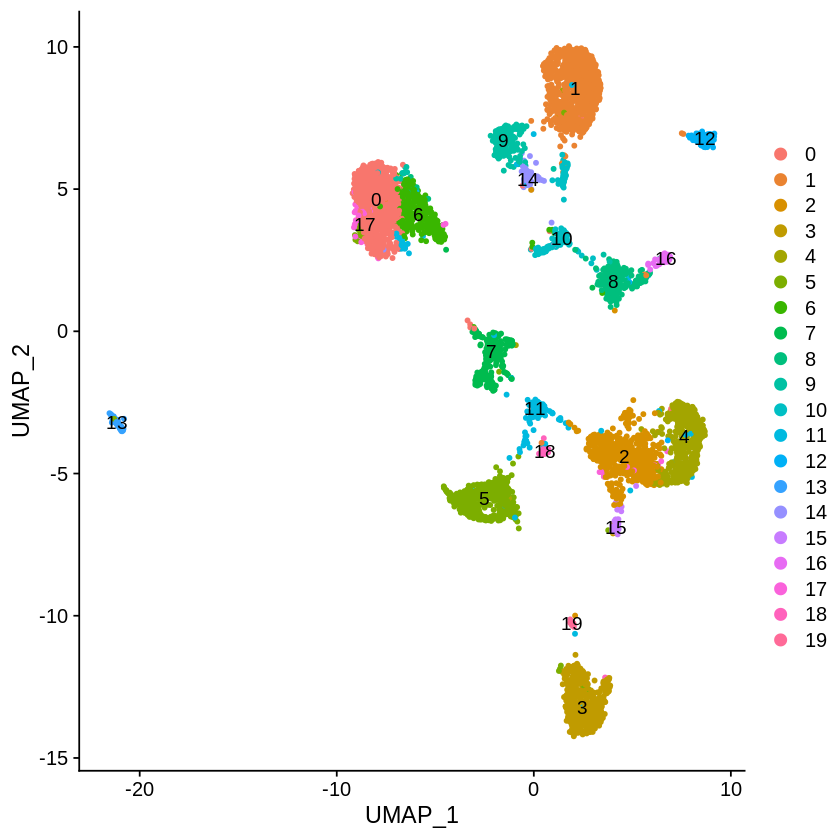

In [15]:
p_umap

# Finding cluster markers 

In [16]:
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

Calculating cluster 0
Calculating cluster 1
Calculating cluster 2
Calculating cluster 3
Calculating cluster 4
Calculating cluster 5
Calculating cluster 6
Calculating cluster 7
Calculating cluster 8
Calculating cluster 9
Calculating cluster 10
Calculating cluster 11
Calculating cluster 12
Calculating cluster 13
Calculating cluster 14
Calculating cluster 15
Calculating cluster 16
Calculating cluster 17
Calculating cluster 18
Calculating cluster 19


# Annotation

In [4]:
dataobj <- readRDS(paste0(datasetName,".seuratobj.rds"))

In [13]:
dataobj.markers <- read.table(paste0(datasetName,".seurat.markers.txt"), sep = "\t", h = T)


In [79]:
dataobj.markers[dataobj.markers['cluster']==18,]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
2148,0.000000e+00,3.0034187,0.600,0.002,0.000000e+00,18,MZB1
2149,1.061561e-298,6.4263680,0.600,0.007,2.368872e-294,18,IGKC
2150,6.342850e-214,6.0048539,0.556,0.010,1.415407e-209,18,IGHA1
2151,2.106064e-206,4.9053895,0.911,0.034,4.699683e-202,18,JCHAIN
2152,1.775683e-189,1.9294296,0.267,0.002,3.962437e-185,18,DERL3
2153,3.992436e-172,3.9086397,0.356,0.005,8.909120e-168,18,IGHA2
2154,4.899725e-55,1.6825107,0.333,0.016,1.093374e-50,18,FKBP11
2155,3.316924e-48,4.8405742,0.422,0.032,7.401715e-44,18,IGHG1
2156,9.756463e-35,1.9208464,0.867,0.203,2.177155e-30,18,SSR4


In [76]:
dataobj.markers[dataobj.markers['gene']=='ACKR1',]

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
572,0,2.413279,0.719,0.064,0,4,ACKR1


In [80]:
new.cluster.ids <- c('Lung-Epithelial Tissue-Type II alveolar cell-SFTPC SFTPD',#0
                     'Lung-Connective Tissue-Fibrocyte-DCN LUM',
                     'Lung-Epithelial Tissue-Endothelial cell-PODXL IFI27',
                     'Lung-Connective Tissue-Macrophage-APOC1 FCGR3A',
                     'Lung-Epithelial Tissue-Vascular endothelial cell-ACKR1 EMCN',
                     'Lung-Connective Tissue-Dendritic cell-IL1B HLA-DRA',#5
                     'Lung-Epithelial Tissue-Type I alveolar cell-EMP2 AQP4',
                     'Lung-Connective Tissue-Mast cell-TPSAB1 CPA3',
                     'Lung-Epithelial Tissue-Club cell-SCGB3A2',
                     'Lung-Musle Tissue-Smooth muscle cell-ACTA2 MYL9',
                     'Lung-Connective Tissue-NK cell-TOP2A CDK1',#10
                     'Lung-Connective Tissue-T cell-GZMB LDHB',
                     'Lung-Epithelial Tissue-Lymphatic endothelial cell-FABP4 CCL21',
                     'Lung-Epithelial Tissue-Perineural epithelial cell-CXCL1 KRT19',
                     'Lung-Musle Tissue-Smooth muscle cell-ACTA2 MYL9',
                     'Lung-Epithelial Tissue-Vascular endothelial cell-GJA5',#15
                     'Lung-Epithelial Tissue-Perineural epithelial cell-CXCL1 KRT19',
                     'Lung-Epithelial Tissue-Type II alveolar cell-SFTPC SFTPD',
                     'Lung-Connective Tissue-B cell-MZB1 JCHAIN',
                     'Lung-Connective Tissue-Macrophage-CD14 FCGR3A'#19
                     )

In [81]:
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)
plot <- DimPlot(dataobj, reduction = "umap",label = TRUE, pt.size = 1) + NoLegend()

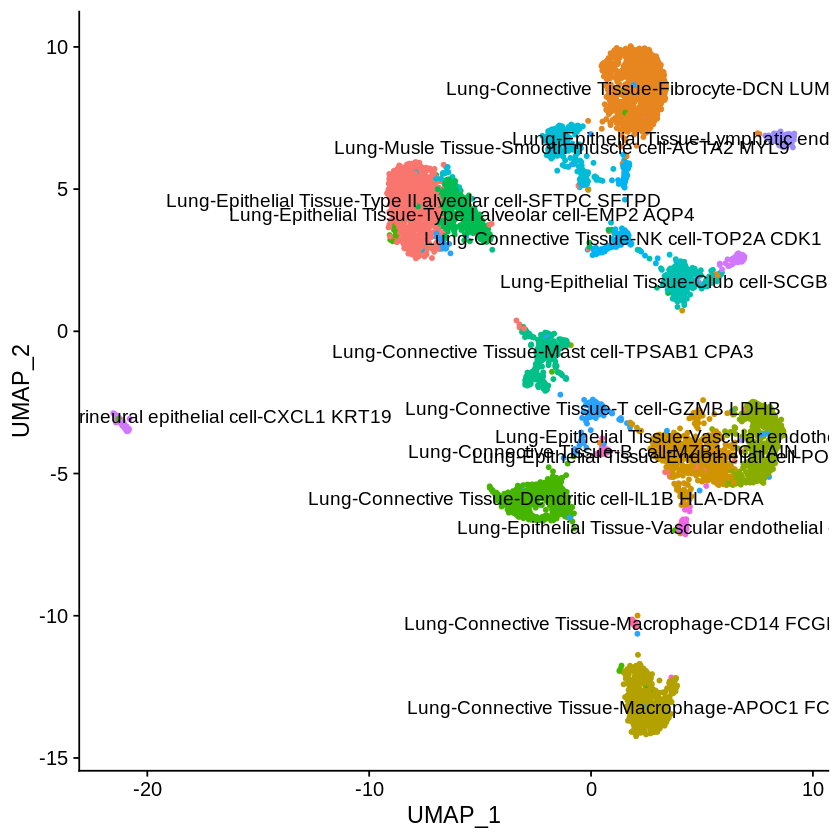

In [82]:
plot

In [83]:
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = plot, width = 8, height = 5)

In [84]:
dataobj@meta.data$hcad.label <- Idents(dataobj)

In [85]:
saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [86]:
df_hca <- data.frame(rownames(dataobj@meta.data),dataobj@meta.data$hcad.label)
colnames(df_hca) <- c('cell_ID', 'cell_cluster')

In [87]:
write.table(df_hca, file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = T)

# update annotation

In [78]:
dataobj <- readRDS("/stor/public/hcad/db_v1/lung_lung_HCLAdultLung2/lung_lung_HCLAdultLung2.seuratobj.dbupload_v1.rds")

In [79]:
dataobj

An object of class Seurat 
43878 features across 6022 samples within 1 assay 
Active assay: RNA (43878 features, 0 variable features)

In [80]:
table(dataobj$original_name[dataobj$hcad_name == "Lung-Connective tissue-NK cell-TOP2A CDK1"])


                                       AT1 cell 
                                              6 
                                       AT2 cell 
                                             12 
                                     Clara cell 
                                              3 
                                 Dendritic cell 
                                              1 
                  Endothelial cell_TMEM100 high 
                                              1 
                   Epithelial cell_PLA2G2A high 
                                              1 
                                     Fibroblast 
                                             19 
                                     Neutrophil 
                                              2 
Proliferating alveolar bipotent progenitor cell 
                                             99 
                             Proliferating cell 
                                             23 
                   

In [81]:
dataobj$cell_type[dataobj$hcad_name == "Lung-Connective tissue-NK cell-TOP2A CDK1"] <- "Type II alveolar cell"
dataobj$tissue_type[dataobj$hcad_name == "Lung-Connective tissue-NK cell-TOP2A CDK1"] <- "Epithelial tissue"
dataobj$marker_gene[dataobj$hcad_name == "Lung-Connective tissue-NK cell-TOP2A CDK1"] <- "SFTPC SFTPD"
dataobj$hcad_name[dataobj$hcad_name == "Lung-Connective tissue-NK cell-TOP2A CDK1"] <- 'Lung-Epithelial tissue-Type II alveolar cell-SFTPC SFTPD'

In [82]:
saveRDS(dataobj, "/stor/public/hcad/db_v1.1/lung_lung_HCLAdultLung2/lung_lung_HCLAdultLung2.seuratobj.dbupload_v1.rds")